## Anomaly Exploration (understanding 'Odd')
In this notebook we use the ZAT Python module for processing, transformation and anomaly detection on Zeek network data. We have a look at 'normal' HHTP traffic and demonstrate the use of Isolation Forests for anomaly detection. Then, we explore those anomalies with clustering and PCA.

**Software**
- ZAT: https://github.com/SuperCowPowers/zat
- Pandas: https://github.com/pandas-dev/pandas
- Scikit-Learn: http://scikit-learn.org/stable/index.html

**Techniques**
- One Hot Encoding: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html
- Isolation Forest: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
- PCA: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

**Related Notebooks**
- Zeek to Scikit-Learn: https://nbviewer.jupyter.org/github/SuperCowPowers/zat/blob/main/notebooks/Zeek_to_Scikit_Learn.ipynb

**Note:** This notebook is a version of notebook provide by Jupiter adapted for our aims 

In [122]:
import zat
from zat.log_to_dataframe import LogToDataFrame
from zat.dataframe_to_matrix import DataFrameToMatrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# print('zat: {:s}'.format(zat.__version__))
# print('Pandas: {:s}'.format(pd.__version__))
# print('Numpy: {:s}'.format(np.__version__))
# print('Scikit Learn Version:', sklearn.__version__)

In [123]:
# Create a Pandas dataframe from a Zeek log
log_to_df = LogToDataFrame()
# zeek_df = log_to_df.create_dataframe('dns.log')
zeek_df = log_to_df.create_dataframe('conn.log')
print('Read in {:d} Rows...'.format(len(zeek_df)))
zeek_df.head()

Read in 353 Rows...


,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
ts,,,,,,,,,,,,,,,,,,,,
2023-03-23 02:09:46.409187072,CUOlN1UTtEoKOi27l,fe80::4c50:74ff:fe3d:f004,133,ff02::2,134,icmp,NaN,NaT,<NA>,<NA>,OTH,NaN,NaN,0,NaN,1,56,0,0,NaN
2023-03-23 02:12:19.978599168,CII3Q33pOb9iSO2549,185.175.0.6,47744,185.175.0.4,1099,tcp,NaN,0 days 00:00:00.012496,208,40,SF,NaN,NaN,0,ShADadFf,7,580,5,308,NaN
2023-03-23 02:12:38.546516992,CAIiou17CANgTVgByk,185.175.0.6,41852,185.175.0.8,1099,tcp,NaN,0 days 00:00:00.010195,208,40,SF,NaN,NaN,0,ShADadFf,7,580,5,308,NaN
2023-03-23 02:12:38.636475136,CgcKpr4m8MF6s0pFCc,185.175.0.6,41864,185.175.0.8,1099,tcp,NaN,0 days 00:02:22.223653,700,19,SF,NaN,NaN,0,ShADadFf,6,1020,4,235,NaN
2023-03-23 02:12:20.052408832,Cxw3PGKoXSIyxGT4e,185.175.0.6,47768,185.175.0.4,1099,tcp,NaN,0 days 00:02:40.807858,700,19,SF,NaN,NaN,0,ShADadFf,6,1020,4,235,NaN


**The code above turned a Zeek log (any log) into a Pandas DataFrame. The ZAT package also supports streaming data from dynamic/active logs, handles log rotations and in general tries to make your life a bit easier when doing data analysis and machine learning on Zeek data.**

**Now that we have the data in a dataframe, we could analyse in many ways for data munging and processing.**

In [124]:
# We're going to pick some features that might be interesting
# some of the features are numerical and some are categorical
# features = ['id.resp_p', 'method', 'resp_mime_types', 'request_body_len'] ##http
features = ['id.resp_p', 'proto', 'duration', 'orig_bytes', 'history', 'id.orig_p'] ##dns
features ##print features

['id.resp_p', 'proto', 'duration', 'orig_bytes', 'history', 'id.orig_p']

## If the features are a mix of numeric and categorical data
When we look at the HTTP records, some of the data is numerical and some is categorical, so we need a way to handle both data types in a generalized way. ZAT has a DataFrameToMatrix class that deals with a lot of the details and mechanics of combining numerical and categorical data and we make use of it below.

In [125]:
# Show the dataframe with mixed feature types
zeek_df[features].head()

,id.resp_p,proto,duration,orig_bytes,history,id.orig_p
ts,,,,,,
2023-03-23 02:09:46.409187072,134,icmp,NaT,<NA>,NaN,133
2023-03-23 02:12:19.978599168,1099,tcp,0 days 00:00:00.012496,208,ShADadFf,47744
2023-03-23 02:12:38.546516992,1099,tcp,0 days 00:00:00.010195,208,ShADadFf,41852
2023-03-23 02:12:38.636475136,1099,tcp,0 days 00:02:22.223653,700,ShADadFf,41864
2023-03-23 02:12:20.052408832,1099,tcp,0 days 00:02:40.807858,700,ShADadFf,47768



## Transformers
**After that, we use a scikit-learn tranformer class to convert the Pandas DataFrame to a numpy ndarray (matrix).**

In [126]:
# This is an optional part that can be used to print out the number of rows and columns
# print(zeek_df[features].shape)
# print(zeek_df['history'].shape)
# print(zeek_df['history'].dropna().shape)
# print(zeek_df[features].dropna(subset=['history']).shape)
# print(zeek_df[features].dropna().shape)

In [127]:
# Use the ZAT DataframeToMatrix class (handles categorical data)
# You can see below it uses a heuristic to detect category data. When doing this, we should explicitly convert before sending to the transformer.
to_matrix = DataFrameToMatrix()
zeek_matrix = to_matrix.fit_transform(zeek_df[features].dropna(subset=['history']), normalize=True) # the dropna method is necessary to drop out the NaN value that are not useful for our purposes
# zeek_matrix = to_matrix.fit_transform(zeek_df[features].dropna(inplace=True), normalize=True) ##alternative
print(zeek_matrix.shape)
zeek_matrix[:1]

Normalizing column id.resp_p...
Normalizing column duration...
Normalizing column orig_bytes...
Normalizing column id.orig_p...
(323, 14)


array([[1.2634386e-02, 1.1570556e-07, 4.5025395e-06, 8.1010437e-01,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [128]:
# Train/fit and Predict anomalous instances using the Isolation Forest model
odd_clf = IsolationForest(contamination=0.25) # Marking 25% odd, this percentage can be changed, for example 0.35. The upper bound of range is 0.5
odd_clf.fit(zeek_matrix)

IsolationForest(contamination=0.25)

In [129]:
# Now we create a new dataframe using the prediction from our classifier

# DEBUG
# print(zeek_df[features].shape)
# print(zeek_matrix.shape)

odd_df = zeek_df[features].dropna(subset=['history'])[odd_clf.predict(zeek_matrix) == -1] ##Dropna is compulsory in this example
print(odd_df.shape)
odd_df.head()

(52, 6)


,id.resp_p,proto,duration,orig_bytes,history,id.orig_p
ts,,,,,,
2023-03-23 02:12:19.978599168,1099,tcp,0 days 00:00:00.012496,208,ShADadFf,47744
2023-03-23 02:12:38.546516992,1099,tcp,0 days 00:00:00.010195,208,ShADadFf,41852
2023-03-23 02:12:38.636475136,1099,tcp,0 days 00:02:22.223653,700,ShADadFf,41864
2023-03-23 02:12:20.052408832,1099,tcp,0 days 00:02:40.807858,700,ShADadFf,47768
2023-03-23 02:12:20.033457152,1099,tcp,0 days 00:02:59.838241,939,ShADadFf,57138


In [130]:
# Now we're going to explore our odd dataframe with help from KMeans and PCA algorithms
odd_matrix = to_matrix.fit_transform(odd_df)

Normalizing column id.resp_p...
Normalizing column duration...
Normalizing column orig_bytes...
Normalizing column id.orig_p...


## Optional


In [131]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")
random_state = 42
# features1 = ['id.resp_p', 'orig_ip_bytes'] # conn.log
features1 = ['id.resp_p', 'orig_bytes', 'id.orig_p'] # dns.log

k_range = list(range(2, 11)) # set the range of k values to test, from 2 to 10 (11-1)
inertias_km = [] # result list that will contain inertias
silhouette_score_km = [] # result list that will contain silhouette_scores
parameters_km = [{'n_clusters': k_range}]
pg_km = list(ParameterGrid(parameters_km))

for i in range(len(pg_km)):
    # print(pg_km[i].get('n_clusters'))
    estimatorKM = KMeans(**(pg_km[i]), random_state = random_state)
    # y_km = estimatorKM.fit_predict(zeek_df[features1])
    y_km = estimatorKM.fit_predict(zeek_df[features1].dropna(subset = 'orig_bytes'))

    inertias_km.append(estimatorKM.inertia_)
    silhouette_score_km.append(silhouette_score(zeek_df[features1].dropna(subset = 'orig_bytes'), y_km))

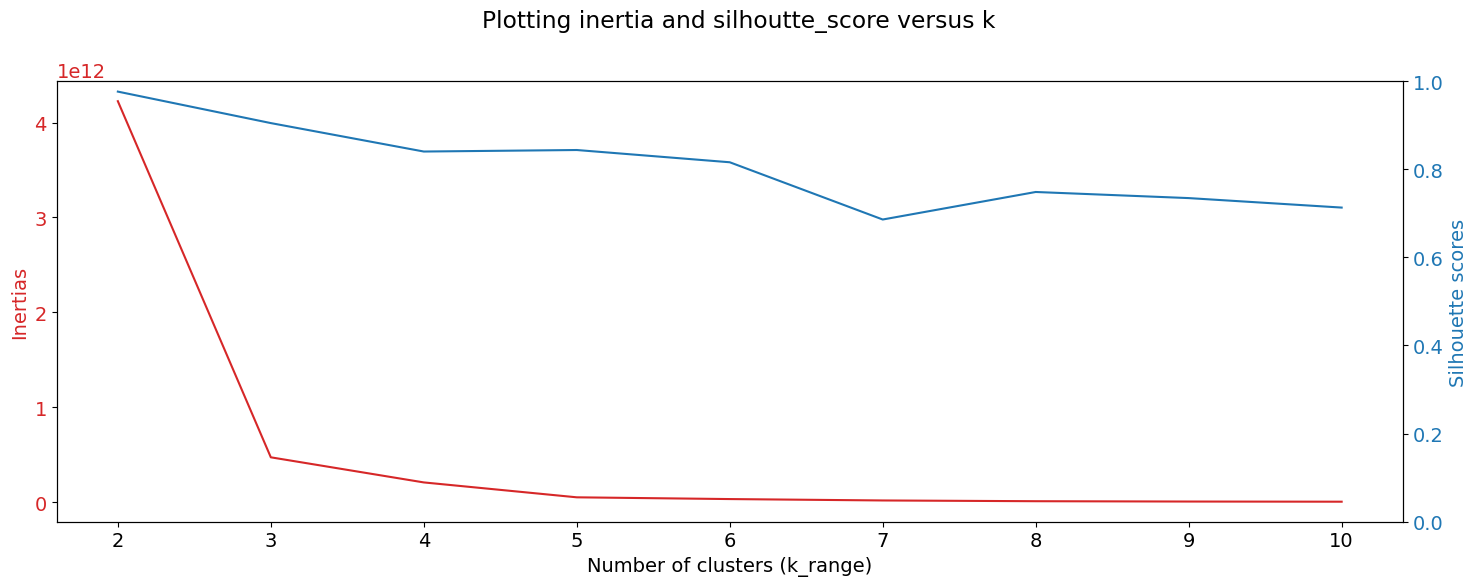

In [132]:
# def two_plots(x, y1, y2, xlabel, y1label, y2label):
fig, ax1 = plt.subplots()
plt.suptitle("Plotting inertia and silhoutte_score versus k")
color = 'tab:red'
ax1.set_xlabel('Number of clusters (k_range)')
ax1.set_ylabel('Inertias', color = color)
ax1.plot(k_range, inertias_km, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Silhouette scores', color = color) # we already handled the x-label with ax1
ax2.plot(k_range, silhouette_score_km, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)
ax2.set_ylim(0, 1) # the axis for silhouette is [0, 1]

fig.tight_layout() # otherwise the right y-label is slightly clipped
plt.show()

In [133]:
k = np.argmax(silhouette_score_km) + 2 # +2 because the list of k_range starts with 2
print(k)

2


## K-Means algorithm and PCA technique

In [134]:
# K-Means and PCA
kmeans = KMeans(n_clusters=3).fit_predict(odd_matrix)
pca = PCA(n_components=3).fit_transform(odd_matrix)

# Now we can put our ML results back onto our dataframe
odd_df['x'] = pca[:, 0] # PCA X Column
odd_df['y'] = pca[:, 1] # PCA Y Column
odd_df['cluster'] = kmeans
odd_df.head()

,id.resp_p,proto,duration,orig_bytes,history,id.orig_p,x,y,cluster
ts,,,,,,,,,
2023-03-23 02:12:19.978599168,1099,tcp,0 days 00:00:00.012496,208,ShADadFf,47744,-27.113140,-0.266448,0
2023-03-23 02:12:38.546516992,1099,tcp,0 days 00:00:00.010195,208,ShADadFf,41852,-27.113092,-0.247373,0
2023-03-23 02:12:38.636475136,1099,tcp,0 days 00:02:22.223653,700,ShADadFf,41864,-27.114092,-0.247411,0
2023-03-23 02:12:20.052408832,1099,tcp,0 days 00:02:40.807858,700,ShADadFf,47768,-27.114214,-0.266525,0
2023-03-23 02:12:20.033457152,1099,tcp,0 days 00:02:59.838241,939,ShADadFf,57138,-27.114336,-0.296861,0


In [135]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14.0
plt.rcParams['figure.figsize'] = 15.0, 6.0

# Helper method for scatter/beeswarm plot
def jitter(arr):
    stdev = .02*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

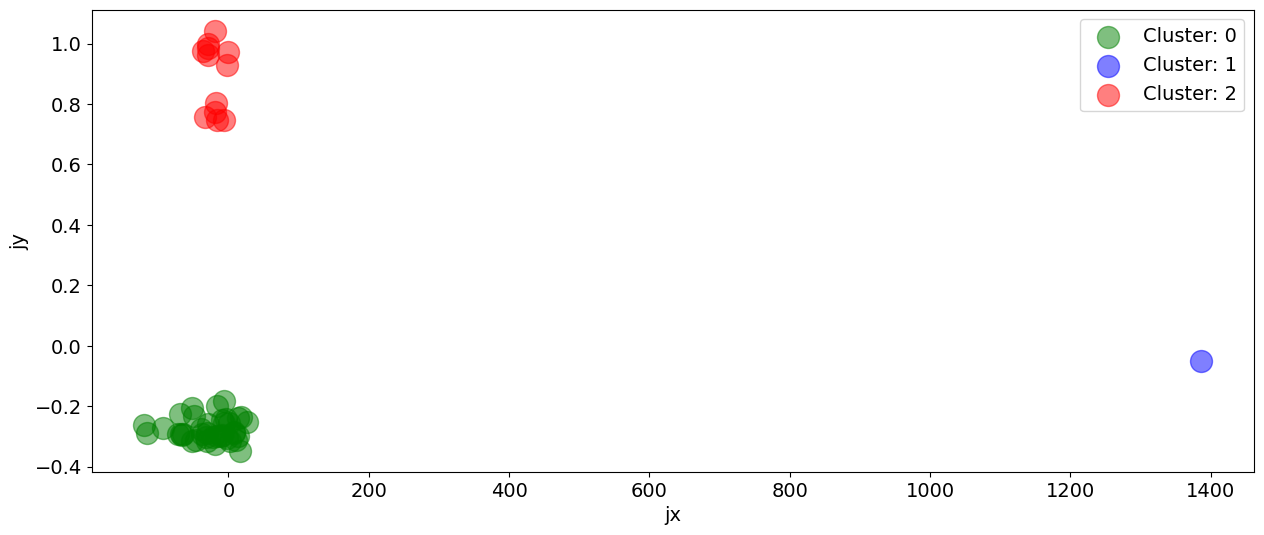

In [136]:
# Jitter so we can see instances that are projected coincident in 2D
odd_df['jx'] = jitter(odd_df['x'])
odd_df['jy'] = jitter(odd_df['y'])

# Now use dataframe group by cluster
cluster_groups = odd_df.groupby('cluster')

# Plot the Machine Learning results
colors = {0:'green', 1:'blue', 2:'red', 3:'orange', 4:'purple', 5:'brown'}
fig, ax = plt.subplots()
for key, group in cluster_groups:
    group.plot(ax=ax, kind='scatter', x='jx', y='jy', alpha=0.5, s=250,
               label='Cluster: {:d}'.format(key), color=colors[key])

In [137]:
# Now print out the details for each cluster
pd.set_option('display.width', 1000)
for key, group in cluster_groups:
    print('\nCluster {:d}: {:d} observations'.format(key, len(group)))
    print(group[features].head())


Cluster 0: 39 observations
                               id.resp_p proto               duration  orig_bytes   history  id.orig_p
ts                                                                                                    
2023-03-23 02:12:19.978599168       1099   tcp 0 days 00:00:00.012496         208  ShADadFf      47744
2023-03-23 02:12:38.546516992       1099   tcp 0 days 00:00:00.010195         208  ShADadFf      41852
2023-03-23 02:12:38.636475136       1099   tcp 0 days 00:02:22.223653         700  ShADadFf      41864
2023-03-23 02:12:20.052408832       1099   tcp 0 days 00:02:40.807858         700  ShADadFf      47768
2023-03-23 02:12:20.033457152       1099   tcp 0 days 00:02:59.838241         939  ShADadFf      57138

Cluster 1: 1 observations
                               id.resp_p proto duration  orig_bytes history  id.orig_p
ts                                                                                    
2023-03-23 02:31:40.939641088        502   tcp    

## Categorical variables that are anomalous
- Cluster 1: duration  orig_bytes history  id.orig_p
- Cluster 2: history

## Numerical variable outliers
- Cluster 0 and 2: The orig_bytes 



For this log almost all orig_bytes are 0



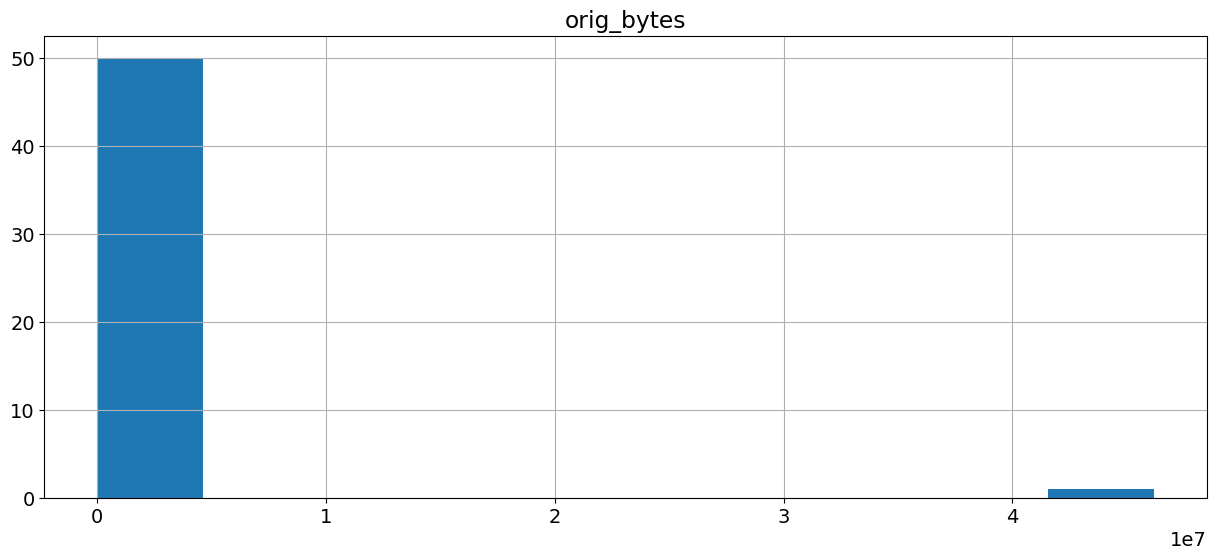

In [138]:
# Distribution of the orig_bytes length
zeek_df[['orig_bytes']].hist()
print('\nFor this log almost all orig_bytes are 0\n')